In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import os

In [2]:
#connect to the S&P 500 database file and create an associated cursor
conn = sqlite3.connect("SP500_stats_5y.db")
c = conn.cursor()

In [3]:
c.execute("SELECT * FROM CompanyInfo")
companies_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])

AllSymbols = list(companies_df['Symbol'])

print("Companies excluded from analysis:")
#Let's skip the stocks without a full data set for simplicity
Skips = []
for Symbol in AllSymbols:
    c.execute("SELECT * FROM "+Symbol.replace('.','_')+"_stats")
    test_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])
    
    if not len(test_df)==1281:
        print(Symbol, len(test_df),list(test_df['Date'])[0],list(test_df['Date'])[-1])
        Skips.append(Symbol)

for sym in Skips:
    AllSymbols.remove(sym)

Companies excluded from analysis:
CARR 484 2020-03-19 2022-02-16
CDAY 961 2018-04-26 2022-02-16
CEG 21 2022-01-19 2022-02-16
CTVA 690 2019-05-24 2022-02-16
DOW 736 2019-03-20 2022-02-16
FOXA 742 2019-03-12 2022-02-16
FOX 741 2019-03-13 2022-02-16
IR 1201 2017-05-12 2022-02-16
MRNA 805 2018-12-07 2022-02-16
OGN 193 2021-05-14 2022-02-16
OTIS 484 2020-03-19 2022-02-16


In [4]:
#Get the general S&P 500 index value to include for comparison
c.execute("SELECT * FROM GSPC_stats")
SP500_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])

In [5]:
def DailyStockPlot(Symbol):
    c.execute("SELECT * FROM "+Symbol.replace('.','_')+"_stats")
    stats_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])
    
    return stats_df

def PairTradeCalc(Symbol1,Symbol2,train_dates,test_dates):
    train_dates = [int(train_dates[0]),int(train_dates[1])]
    test_dates  = [int(test_dates[0]) , int(test_dates[1])]
    
    stats1_df = DailyStockPlot(Symbol1)
    stats2_df = DailyStockPlot(Symbol2)
        
    S1TrainCloses = stats1_df[(stats1_df['date_int'] >= train_dates[0] ) & (stats1_df['date_int'] <= train_dates[1] ) ]['Close']
    S2TrainCloses = stats2_df[(stats2_df['date_int'] >= train_dates[0] ) & (stats2_df['date_int'] <= train_dates[1] ) ]['Close']
    S1Scale = np.mean(S1TrainCloses)
    S2Scale = np.mean(S2TrainCloses)
    
    AvgDiff = np.mean( S1TrainCloses/S1Scale - S2TrainCloses/S2Scale )
    
    stats1_df = stats1_df[(stats1_df['date_int'] >= test_dates[0] ) & (stats1_df['date_int'] <= test_dates[1] ) ]
    stats2_df = stats2_df[(stats2_df['date_int'] >= test_dates[0] ) & (stats2_df['date_int'] <= test_dates[1] ) ]
    SP500Comp_df = SP500_df[(SP500_df['date_int'] >= test_dates[0] ) & (SP500_df['date_int'] <= test_dates[1] ) ]
    
    InitFunds = 100000.0
    AvailableFunds = InitFunds

    CurrentValues = []

    Symbol1Position = 'None'
    Symbol2Position = 'None'

    Symbol1Shares = 0.0
    Symbol2Shares = 0.0

    LongCost1 = 0.0
    LongCost2 = 0.0

    ShortFunds1 = 0.0
    ShortFunds2 = 0.0

    for i in list(stats1_df.index)[0:-1]:
        DailyFunds = AvailableFunds

        printstats = False

        if (stats1_df['Close'][i]/S1Scale - stats2_df['Close'][i]/S2Scale) > AvgDiff:
            #want to short S1 / long S2
            #print('We expect that '+Symbol1+' will drop in price relative to '+Symbol2+' in the near(ish) future.')
            #print("Thus, we'd like to be in a short position for "+Symbol1+" and a long position for "+Symbol2+".")

            if Symbol1Position == 'None':
                #Set up a short position worth half of the available funds on symbol 1 shares at the next open
                Symbol1Shares = -0.5*DailyFunds/stats1_df['Open'][i+1]
                ShortFunds1 = 0.5*DailyFunds
                AvailableFunds = AvailableFunds - ShortFunds1
                Symbol1Position = 'Short'
                #print('Opening short position on '+Symbol1+': $'+str(round(ShortFunds1,2))+' / '+str(round(-Symbol1Shares,2))+' shares')
                printstats = True

            if Symbol1Position == 'Long':
                #Sell currently owned symbol 1 shares at the next open
                #print('Closing long position on '+Symbol1+', netting $'+str(round(stats1_df['Open'][i+1]*Symbol1Shares-LongCost1,2)))
                AvailableFunds += stats1_df['Open'][i+1]*Symbol1Shares
                Symbol1Shares = 0.0
                Symbol1Position = 'None'
                printstats = True

            if Symbol2Position == 'None':
                #Spend half of available funds on symbol 2 shares at the next open
                #print('Opening long position on '+Symbol2+': $'+str(round(0.5*DailyFunds,2))+' / '+str(round(0.5*DailyFunds/stats2_df['Open'][i+1],2))+' shares')
                Symbol2Shares = 0.5*DailyFunds/stats2_df['Open'][i+1]
                AvailableFunds = AvailableFunds - 0.5*DailyFunds
                LongCost2 = 0.5*DailyFunds
                Symbol2Position = 'Long'
                printstats = True

            if Symbol2Position == 'Short':
                #Close out the symbol 2 short position
                #print('Closing short position on '+Symbol2+', netting $'+str(round(ShortFunds2+Symbol2Shares*stats2_df['Open'][i+1],2)))
                AvailableFunds += 2*ShortFunds2+Symbol2Shares*stats2_df['Open'][i+1]
                Symbol2Shares = 0.0
                ShortFunds2 = 0.0
                Symbol2Position = 'None'
                printstats = True

        elif (stats1_df['Close'][i]/S1Scale - stats2_df['Close'][i]/S2Scale) < AvgDiff:
            #want to long S1 / short S2
            #print('We expect that '+Symbol1+' will rise in price relative to '+Symbol2+' in the near(ish) future.')
            #print("Thus, we'd like to be in a long position for "+Symbol1+" and a short position for "+Symbol2+".")

            if Symbol1Position == 'None':
                #Spend half of available funds on symbol 1 shares at the next open
                #print('Opening long position on '+Symbol1+': $'+str(round(0.5*DailyFunds,2))+' / '+str(round(0.5*DailyFunds/stats1_df['Open'][i+1],2))+' shares')
                Symbol1Shares = 0.5*DailyFunds/stats1_df['Open'][i+1]
                AvailableFunds = AvailableFunds - 0.5*DailyFunds
                LongCost1 = 0.5*DailyFunds
                Symbol1Position = 'Long'
                printstats = True

            if Symbol1Position == 'Short':
                #Close out the symbol 1 short position
                #print('Closing short position on '+Symbol1+', netting $'+str(round(ShortFunds1+Symbol1Shares*stats1_df['Open'][i+1],2)))
                AvailableFunds += 2*ShortFunds1+Symbol1Shares*stats1_df['Open'][i+1]
                Symbol1Shares = 0.0
                ShortFunds1 = 0.0
                Symbol1Position = 'None'
                printstats = True

            if Symbol2Position == 'None':
                #Set up a short position worth half of the available funds on symbol 2 shares at the next open
                Symbol2Shares = -0.5*DailyFunds/stats2_df['Open'][i+1]
                ShortFunds2 = 0.5*DailyFunds
                AvailableFunds = AvailableFunds - ShortFunds2
                Symbol2Position = 'Short'
                #print('Opening short position on '+Symbol2+': $'+str(round(ShortFunds2,2))+' / '+str(round(-Symbol2Shares,2))+' shares')
                printstats = True

            if Symbol2Position == 'Long':
                #Sell currently owned symbol 2 shares at the next open
                #print('Closing long position on '+Symbol2+', netting $'+str(round(stats2_df['Open'][i+1]*Symbol2Shares-LongCost2,2)))
                AvailableFunds += stats2_df['Open'][i+1]*Symbol2Shares
                Symbol2Shares = 0.0
                Symbol2Position = 'None'
                printstats = True


    #Close out all positions on the final day
    i = list(stats1_df.index)[-1]
    if Symbol1Position == 'Long':
        #Sell currently owned symbol 1 shares at the final open
        #print('Closing long position on '+Symbol1+', netting $'+str(round(stats1_df['Open'][i]*Symbol1Shares-LongCost1,2)))
        AvailableFunds += stats1_df['Open'][i]*Symbol1Shares
        Symbol1Shares = 0.0
        Symbol1Position = 'None'
    if Symbol2Position == 'Long':
        #Sell currently owned symbol 2 shares at the final open
        #print('Closing long position on '+Symbol2+', netting $'+str(round(stats2_df['Open'][i]*Symbol2Shares-LongCost2,2)))
        AvailableFunds += stats2_df['Open'][i]*Symbol2Shares
        Symbol2Shares = 0.0
        Symbol2Position = 'None'
    if Symbol1Position == 'Short':
        #Close out the symbol 1 short position
        #print('Closing short position on '+Symbol1+', netting $'+str(round(ShortFunds1+Symbol1Shares*stats1_df['Open'][i],2)))
        AvailableFunds += 2*ShortFunds1+Symbol1Shares*stats1_df['Open'][i]
        Symbol1Shares = 0.0
        ShortFunds1 = 0.0
        Symbol1Position == 'None'
    if Symbol2Position == 'Short':
        #Close out the symbol 2 short position
        #print('Closing short position on '+Symbol2+', netting $'+str(round(ShortFunds2+Symbol2Shares*stats2_df['Open'][i],2)))
        AvailableFunds += 2*ShortFunds2+Symbol2Shares*stats2_df['Open'][i]
        Symbol2Shares = 0.0
        ShortFunds2 = 0.0
        Symbol2Position == 'None'
    CurrentValues.append(AvailableFunds)
    
    BaselineFund  =  InitFunds*SP500Comp_df['Open'][SP500Comp_df.index[-1]]/SP500Comp_df['Open'][SP500Comp_df.index[0]]
    BaselineFund1 =  InitFunds*stats1_df['Open'][stats1_df.index[-1]]/stats1_df['Open'][stats1_df.index[0]]
    BaselineFund2 =  InitFunds*stats2_df['Open'][stats2_df.index[-1]]/stats2_df['Open'][stats2_df.index[0]]
    
    return(100.0*AvailableFunds/InitFunds,
           100.0*(BaselineFund)/InitFunds,
           100.0*BaselineFund1/InitFunds,
           100.0*BaselineFund2/InitFunds,
           AvgDiff, S1Scale, S2Scale)


In [6]:
if os.path.isfile('finding_pairs_stats.csv'):
    print('Dataframe already computed. Importing now.')
    find_pairs_df = pd.read_csv('finding_pairs_stats.csv')
    find_pairs_df = find_pairs_df.sort_values(by='MeanPairsRatio',ascending=False).reset_index(drop=True).drop('Unnamed: 0',1)
else:
    print("\t\t\t\tRatio of Pair Trading to General S&P 500 Index")
    print("Symbol1\t\tSymbol2\t\tTest Year One\tTest Year Two\tTest Year Three\t\tThree Year Average")

    find_pairs_df = pd.DataFrame(columns = ['Symbol1','S1Sector','S1Industry',
                                            'Symbol2','S2Sector','S2Industry',
                                            'PairTrade1','SP500Trade1',
                                            'PairTrade2','SP500Trade2',
                                            'PairTrade3','SP500Trade3',
                                            'MeanPairsRatio','LastAvgDiff','LastSymbol1Mean','LastSymbol2Mean',
                                            'TotSigma','6moAvg','12moAvg'])

    ints_6mo = [[0,182],[183,365],[366,547],[548,730],[731,912],[913,1095],[1096,1277],[1288,1460]]
    ints_12mo = [[0,365],[366,730],[731,1095],[1096,1460]]

    for TestSymbol in AllSymbols:
        c.execute("SELECT * FROM "+TestSymbol.replace('.','_')+"_stats WHERE date_int < 1461")
        test_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])
        
        #Skip comparing TestSymbol to itself and skip if the S1/S2 pair has been computed previously
        CompSymbols = list(AllSymbols)
        CompSymbols.remove(TestSymbol)
        done_list = list(find_pairs_df[find_pairs_df['Symbol2']==TestSymbol]['Symbol1'])
        for DoneSymbol in done_list:
            CompSymbols.remove(DoneSymbol)
        
        for CompSymbol in CompSymbols:
            c.execute("SELECT * FROM "+CompSymbol.replace('.','_')+"_stats WHERE date_int < 1461")
            comp_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])

            TotSigma = np.std(comp_df['Close']/np.mean(comp_df['Close']) - test_df['Close']/np.mean(test_df['Close']))

            MeanDiff = np.mean(comp_df['Close']/np.mean(comp_df['Close']) - test_df['Close']/np.mean(test_df['Close']))

            AvgOffsets_6mo = []
            for intset in ints_6mo:
                CompComponent = comp_df[(comp_df['date_int']>=intset[0])&(comp_df['date_int']<=intset[1])]['Close']/np.mean(comp_df[(comp_df['date_int']>=intset[0])&(comp_df['date_int']<=intset[1])]['Close'])
                TestComponent = test_df[(test_df['date_int']>=intset[0])&(test_df['date_int']<=intset[1])]['Close']/np.mean(test_df[(test_df['date_int']>=intset[0])&(test_df['date_int']<=intset[1])]['Close'])
                AvgDiff = np.mean( CompComponent - TestComponent)
                AvgOffsets_6mo.append(np.abs(AvgDiff-MeanDiff))
            Avg6mo = np.mean(AvgOffsets_6mo)

            AvgOffsets_12mo = []
            for intset in ints_12mo:
                CompComponent = comp_df[(comp_df['date_int']>=intset[0])&(comp_df['date_int']<=intset[1])]['Close']/np.mean(comp_df[(comp_df['date_int']>=intset[0])&(comp_df['date_int']<=intset[1])]['Close'])
                TestComponent = test_df[(test_df['date_int']>=intset[0])&(test_df['date_int']<=intset[1])]['Close']/np.mean(test_df[(test_df['date_int']>=intset[0])&(test_df['date_int']<=intset[1])]['Close'])
                AvgDiff = np.mean( CompComponent - TestComponent)
                AvgOffsets_12mo.append(np.abs(AvgDiff-MeanDiff))
            Avg12mo = np.mean(AvgOffsets_12mo)

            #Now do the idealized Pair Trade calculations
            PairTrade1,SP500Trade1,Symbol1Trade1,Symbol2Trade1,LastAvgDiff,S1Scale,S2Scale = PairTradeCalc(TestSymbol,
                                                                                               CompSymbol,
                                                                                               ints_12mo[0],
                                                                                               ints_12mo[1])
            PairTrade2,SP500Trade2,Symbol1Trade2,Symbol2Trade2,LastAvgDiff,S1Scale,S2Scale = PairTradeCalc(TestSymbol,
                                                                                               CompSymbol,
                                                                                               ints_12mo[1],
                                                                                               ints_12mo[2])
            PairTrade3,SP500Trade3,Symbol1Trade3,Symbol2Trade3,LastAvgDiff,S1Scale,S2Scale = PairTradeCalc(TestSymbol,
                                                                                               CompSymbol,
                                                                                               ints_12mo[2],
                                                                                               ints_12mo[3])
            MeanPairsRatio = 100.0*(PairTrade1+PairTrade2+PairTrade3)/(SP500Trade1+SP500Trade2+SP500Trade3)
            
            S1Sector = list(companies_df[companies_df['Symbol']==TestSymbol]['Sector'])[0]
            S2Sector = list(companies_df[companies_df['Symbol']==CompSymbol]['Sector'])[0]
            S1Industry = list(companies_df[companies_df['Symbol']==TestSymbol]['Industry'])[0]
            S2Industry = list(companies_df[companies_df['Symbol']==CompSymbol]['Industry'])[0]
            
            find_pairs_df = find_pairs_df.append({'Symbol1':TestSymbol,'S1Sector':S1Sector,'S1Industry':S1Industry,
                                            'Symbol2':CompSymbol,'S2Sector':S2Sector,'S2Industry':S2Industry,
                                            'PairTrade1':PairTrade1,'SP500Trade1':SP500Trade1,
                                            'PairTrade2':PairTrade2,'SP500Trade2':SP500Trade2,
                                            'PairTrade3':PairTrade3,'SP500Trade3':SP500Trade3,
                                            'MeanPairsRatio':MeanPairsRatio,'LastAvgDiff':LastAvgDiff,
                                            'LastSymbol1Mean':S1Scale,'LastSymbol2Mean':S2Scale,
                                            'TotSigma':TotSigma,'6moAvg':Avg6mo, '12moAvg':Avg12mo},
                                            ignore_index = True)

            if PairTrade1 > SP500Trade1 and PairTrade2 > SP500Trade2 and PairTrade3 > SP500Trade3:
                print( TestSymbol+'\t\t'+CompSymbol+'\t\t'+str(round(100.0*PairTrade1/SP500Trade1,1))+'%\t\t'+str(round(100.0*PairTrade2/SP500Trade2,1)) +'%\t\t'+str(round(100.0*PairTrade3/SP500Trade3,1))+'%\t\t\t'+str(round(MeanPairsRatio,1))+'%' )
    
    find_pairs_df = find_pairs_df.sort_values(by='MeanPairsRatio',ascending=False).reset_index(drop=True)
    find_pairs_df.to_csv('finding_pairs_stats.csv')

Dataframe already computed. Importing now.


In [7]:
find_pairs_df


,Symbol1,S1Sector,S1Industry,Symbol2,S2Sector,S2Industry,PairTrade1,SP500Trade1,PairTrade2,SP500Trade2,PairTrade3,SP500Trade3,MeanPairsRatio,LastAvgDiff,LastSymbol1Mean,LastSymbol2Mean,TotSigma,6moAvg,12moAvg
0,AAL,Industrials,Airlines,APA,Energy,Oil & Gas E&P,153.156120,94.600368,155.414642,125.04929,240.999797,114.082979,164.673903,2.830848e-17,30.365462,26.391106,0.185951,6.186303e-17,9.445431e-17
1,UAA,Consumer Cyclical,Apparel Manufacturing,VTR,Real Estate,REIT—Healthcare Facilities,128.047603,94.600368,139.914720,125.04929,266.889216,114.082979,160.263481,-4.246271e-17,21.550598,57.579155,0.173833,7.781501e-17,1.586599e-16
2,PXD,Energy,Oil & Gas E&P,WYNN,Consumer Cyclical,Resorts & Casinos,119.593367,94.600368,136.382649,125.04929,275.753610,114.082979,159.328027,-9.200255e-17,130.673107,121.001743,0.171217,7.416087e-17,3.979443e-17
3,AAL,Industrials,Airlines,FANG,Energy,Oil & Gas E&P,87.636641,94.600368,128.540957,125.04929,302.104377,114.082979,155.298559,5.705927e-17,30.365462,91.046464,0.218074,4.948912e-17,5.504498e-17
4,HES,Energy,Oil & Gas E&P,ULTA,Consumer Cyclical,Specialty Retail,120.579899,94.600368,125.783828,125.04929,269.205452,114.082979,154.485694,-7.077119e-17,59.550600,299.323109,0.182434,6.519654e-17,5.426574e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122755,AAL,Industrials,Airlines,ENPH,Technology,Solar,-50.803680,94.600368,-90.762267,125.04929,-198.343338,114.082979,-101.850777,-5.661695e-17,30.365462,18.798287,1.795689,9.086912e-17,1.764509e-16
122756,ENPH,Technology,Solar,REGN,Healthcare,Biotechnology,-24.123321,94.600368,-86.590170,125.04929,-234.502064,114.082979,-103.440754,8.492543e-17,18.798287,342.344104,1.374589,1.392995e-16,1.972414e-16
122757,EOG,Energy,Oil & Gas E&P,PENN,Consumer Cyclical,Resorts & Casinos,137.561992,94.600368,110.584790,125.04929,-599.718360,114.082979,-105.345279,1.344653e-16,76.879122,21.336175,0.710594,5.794773e-17,1.218697e-16
122758,CTXS,Technology,Software—Application,ENPH,Technology,Solar,-21.820131,94.600368,-79.649702,125.04929,-260.580727,114.082979,-108.485212,-2.830848e-17,99.295795,18.798287,1.359047,7.315520e-17,2.613329e-17


In [8]:
f = open("LikelyPairStocks.txt", "w")
print("Symbol1\tSymbol2\tLast Avg. Diff.\t\tLast S1 Mean\t\tLast S2 Mean\t\tAvg. Ratio")
f.write("\tSymbol1\t\tSymbol2\t\tPairTrade\tSymbol1Trade\tSymbol2Trade\tSP500Trade"+"\n")
for i in range(len(find_pairs_df)):
    if find_pairs_df['PairTrade1'][i] > find_pairs_df['SP500Trade1'][i] and find_pairs_df['PairTrade2'][i] > find_pairs_df['SP500Trade2'][i] and find_pairs_df['PairTrade3'][i] > find_pairs_df['SP500Trade3'][i]:
        printstr =  find_pairs_df['Symbol1'][i]+'\t'+find_pairs_df['Symbol2'][i]+'\t'+str(find_pairs_df['LastAvgDiff'][i])+'\t'+str(find_pairs_df['LastSymbol1Mean'][i])+'\t'+str(find_pairs_df['LastSymbol2Mean'][i])+'\t'+str(round(find_pairs_df['MeanPairsRatio'][i],1))+'%'
        print(printstr)
        f.write(printstr+"\n")
f.close()
            

Symbol1	Symbol2	Last Avg. Diff.		Last S1 Mean		Last S2 Mean		Avg. Ratio
AAL	APA	2.8308475528290844e-17	30.36546194220919	26.39110628257235	164.7%
UAA	VTR	-4.2462713292436265e-17	21.550597665794346	57.57915536340964	160.3%
PXD	WYNN	-9.200254546694524e-17	130.67310658489092	121.0017433318484	159.3%
HES	ULTA	-7.077118882072711e-17	59.55059964913296	299.32310850591773	154.5%
BKR	WYNN	-3.5385594410363554e-18	21.820666073802933	121.0017433318484	154.1%
CCL	FANG	3.538559441036356e-17	47.88007239231551	91.0464641373471	153.8%
FLT	PEAK	-3.715487413088173e-17	271.98211153189976	29.390038152139976	151.7%
VLO	WYNN	7.430974826176346e-17	74.28138666038969	121.0017433318484	151.2%
CVX	UAA	1.0615678323109066e-17	104.8554801788938	21.550597665794346	144.2%
AAL	DVN	-2.8308475528290844e-17	30.36546194220919	23.4615577302606	142.7%
LUMN	WDC	9.200254546694524e-17	11.18029068190738	50.43285378991845	141.0%
AIG	WYNN	3.538559441036356e-17	46.98957057208179	121.0017433318484	140.3%
K	MU	-5.4847671336063505e-17

IQV	ORLY	2.1231356646218133e-17	145.84039884164514	394.8825897581549	111.9%
CSCO	EXC	-2.1231356646218133e-17	47.60303603700433	30.669482409716604	111.9%
IFF	LUV	-3.5385594410363554e-18	123.36258238530256	52.83127242920408	111.9%
MKC	SHW	7.077118882072711e-18	74.81481249683881	162.3488270125066	111.9%
ARE	KMX	3.8924153851399907e-17	138.41981655288026	81.45940244150351	111.9%
BBY	ROK	-5.661695105658169e-17	66.77334164623245	164.84379735695887	111.8%
HLT	ROST	-3.007775524880902e-17	92.76725428607834	101.61178236273656	111.8%
CBRE	PPL	7.077118882072711e-18	52.16003983334241	27.654412478564744	111.8%
BMY	CAG	-8.227150700409527e-17	47.022757100868986	25.867454612397577	111.8%
AOS	CTSH	-7.607902798228164e-17	46.13046007802287	63.26871647017885	111.8%
FAST	LLY	-6.015551049761804e-17	30.765718498078	111.9482711852784	111.8%
CDNS	TGT	-1.4154237764145422e-17	65.84828672371063	89.99990759617779	111.8%
MCHP	NDSN	-1.8577437065440865e-17	44.33557913122899	141.09161358715528	111.8%
MKC	PHM	2.830847552

MO	SNA	8.846398602590887e-17	40.38756246680757	150.03159359631786	107.2%
MAS	NDSN	-7.430974826176346e-17	39.64013605003813	141.09161358715528	107.1%
HSIC	SEE	1.663122937287087e-16	64.67094448743113	40.38892995218832	107.1%
INFO	NVR	1.7692797205181777e-18	61.94524309074736	3338.889723333229	107.1%
APTV	MU	4.9539832174508976e-17	83.5090025487649	43.49149536801525	107.1%
HCA	INTC	1.7692797205181774e-16	129.37707376670076	49.58377967317741	107.1%
DHI	VMC	1.59235174846636e-17	45.70093322085194	129.29391579798968	107.1%
BF.B	LIN	-3.5385594410363554e-18	55.32411978064305	182.5012243506443	107.1%
DRE	ROST	-3.6270234270622636e-17	30.366976726577576	101.61178236273656	107.1%
NWL	STT	-1.4154237764145422e-17	15.236730161416103	60.16734336761839	107.1%
MU	VZ	0.0	43.49149536801525	51.964229112602325	107.1%
TECH	IDXX	-1.0615678323109066e-17	199.6340913202658	253.5109957508832	107.0%
CAG	CVS	7.607902798228164e-17	25.867454612397577	57.29052596073227	107.0%
KMX	WMT	7.784830770279983e-17	81.459402441503

ANET	SEE	7.430974826176346e-17	61.71735049243942	40.38892995218832	105.1%
MMM	TAP	-9.55411049079816e-17	163.14480615137109	54.06843580572728	105.1%
KMX	CCI	4.6001272733472624e-17	81.45940244150351	122.18935011297584	105.1%
ANTM	LVS	-2.1231356646218133e-17	271.42418734485886	58.432611093103176	105.1%
IDXX	RMD	-1.0615678323109066e-17	253.5109957508832	122.00426759757843	105.1%
ULTA	VNO	-4.2462713292436265e-17	299.32310850591773	55.55739464322884	105.1%
KO	LMT	3.5385594410363554e-18	47.32394173610733	331.9957525853617	105.1%
BBY	LH	6.900190910020892e-17	66.77334164623245	163.35709128816765	105.0%
CHRW	K	5.661695105658169e-17	79.7344851246868	55.10002573932785	105.0%
BKNG	SJM	7.077118882072711e-18	1889.627931146508	102.4575620856418	105.0%
A	FB	2.4769916087254488e-17	74.74333203076367	185.3225893423377	104.9%
RMD	SBAC	-3.5385594410363554e-18	122.00426759757843	220.7497365883147	104.9%
EPAM	NOW	3.5385594410363554e-18	181.92501989113856	260.5661749972765	104.9%
DISH	F	-1.1234926225290429e-16

IEX	ILMN	1.167724615541997e-16	154.1925578326343	310.9597209307302	100.9%
ROST	DIS	1.0615678323109067e-16	101.61178236273656	131.44761204814532	100.8%
MS	TTWO	-5.661695105658169e-17	41.64971265754852	112.813466106278	100.8%


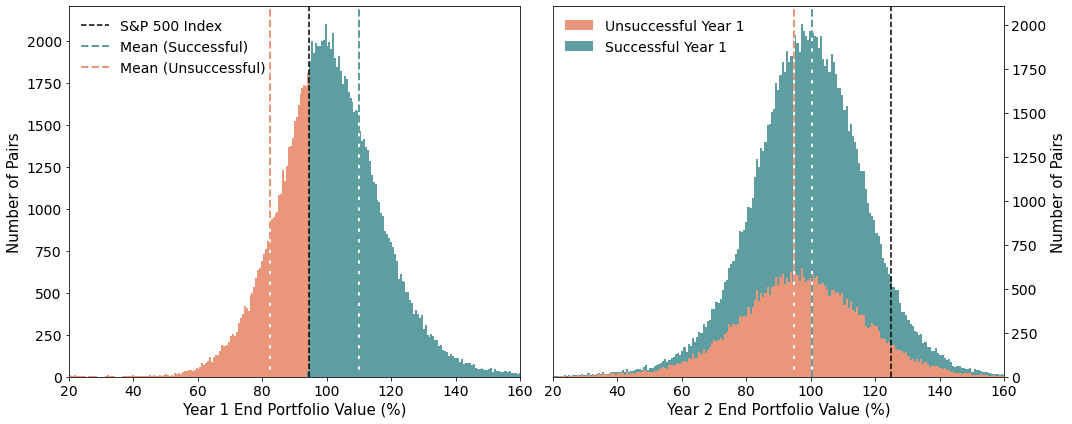

In [10]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)

plt.axvline(find_pairs_df['SP500Trade1'][0],color='k',linestyle='--',linewidth=1.5,label='S&P 500 Index')

SuccessfulData = find_pairs_df[find_pairs_df['PairTrade1']>find_pairs_df['SP500Trade1']]['PairTrade1']
UnsuccessfulData = find_pairs_df[find_pairs_df['PairTrade1']<find_pairs_df['SP500Trade1']]['PairTrade1']

plt.hist([SuccessfulData,UnsuccessfulData], bins=500,color=["cadetblue","darksalmon"], stacked=True)

plt.axvline(np.mean(SuccessfulData),color='white',linestyle='-',linewidth=2)
plt.axvline(np.mean(SuccessfulData),color='cadetblue',linestyle='--',linewidth=2,label='Mean (Successful)')

plt.axvline(np.mean(UnsuccessfulData), color='white',linestyle='-',linewidth=2)
plt.axvline(np.mean(UnsuccessfulData), color='darksalmon',linestyle='--',linewidth=2,label='Mean (Unsuccessful)')

plt.xlabel('Year 1 End Portfolio Value (%)',fontsize=15)
plt.ylabel('Number of Pairs',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(20,160)
#plt.ylim(0,2050)
plt.legend(fontsize=14,loc='best',frameon=False)


plt.subplot(1,2,2)
plt.axvline(find_pairs_df['SP500Trade2'][0],color='k',linestyle='--',linewidth=1.5)

SuccessfulData = find_pairs_df[find_pairs_df['PairTrade1']>find_pairs_df['SP500Trade1']]['PairTrade2']
UnsuccessfulData = find_pairs_df[find_pairs_df['PairTrade1']<find_pairs_df['SP500Trade1']]['PairTrade2']

plt.hist([UnsuccessfulData,SuccessfulData], bins=500, color=["darksalmon","cadetblue"], stacked=True,
        label=["Unsuccessful Year 1","Successful Year 1"])

plt.axvline(np.mean(SuccessfulData),color='white',linestyle='-',linewidth=2)
plt.axvline(np.mean(SuccessfulData),color='cadetblue',linestyle='--',linewidth=2)

plt.axvline(np.mean(UnsuccessfulData), color='white',linestyle='-',linewidth=2)
plt.axvline(np.mean(UnsuccessfulData), color='darksalmon',linestyle='--',linewidth=2)

plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.xlabel('Year 2 End Portfolio Value (%)',fontsize=15)
plt.ylabel('Number of Pairs',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(20,160)
#plt.ylim(0,2050)
plt.legend(fontsize=14,loc='best',frameon=False)

plt.tight_layout()
plt.show()

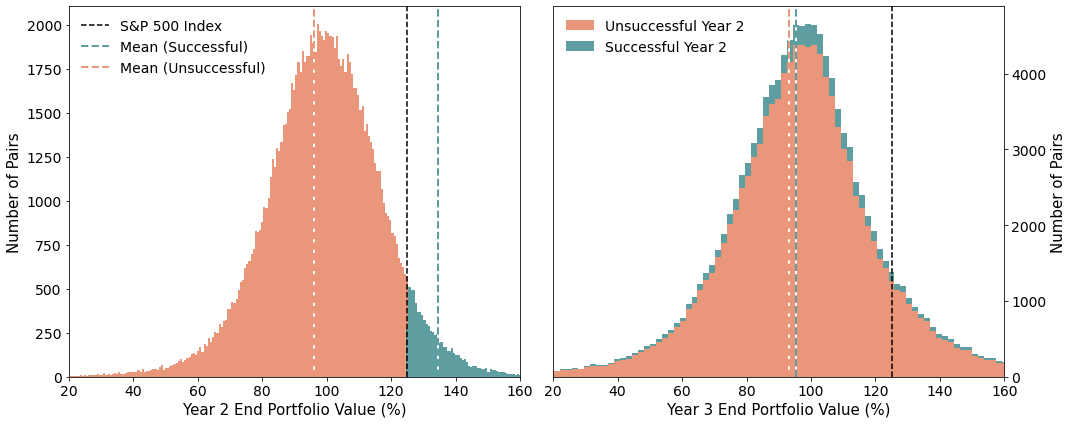

In [11]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)

plt.axvline(find_pairs_df['SP500Trade2'][0],color='k',linestyle='--',linewidth=1.5,label='S&P 500 Index')

SuccessfulData = find_pairs_df[find_pairs_df['PairTrade2']>find_pairs_df['SP500Trade2']]['PairTrade2']
UnsuccessfulData = find_pairs_df[find_pairs_df['PairTrade2']<find_pairs_df['SP500Trade2']]['PairTrade2']

plt.hist([SuccessfulData,UnsuccessfulData], bins=500,color=["cadetblue","darksalmon"], stacked=True)

plt.axvline(np.mean(SuccessfulData),color='white',linestyle='-',linewidth=2)
plt.axvline(np.mean(SuccessfulData),color='cadetblue',linestyle='--',linewidth=2,label='Mean (Successful)')

plt.axvline(np.mean(UnsuccessfulData), color='white',linestyle='-',linewidth=2)
plt.axvline(np.mean(UnsuccessfulData), color='darksalmon',linestyle='--',linewidth=2,label='Mean (Unsuccessful)')

plt.xlabel('Year 2 End Portfolio Value (%)',fontsize=15)
plt.ylabel('Number of Pairs',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(20,160)
#plt.ylim(0,2050)
plt.legend(fontsize=14,loc='best',frameon=False)


plt.subplot(1,2,2)
plt.axvline(find_pairs_df['SP500Trade2'][0],color='k',linestyle='--',linewidth=1.5)

SuccessfulData = find_pairs_df[find_pairs_df['PairTrade2']>find_pairs_df['SP500Trade2']]['PairTrade3']
UnsuccessfulData = find_pairs_df[find_pairs_df['PairTrade2']<find_pairs_df['SP500Trade2']]['PairTrade3']

plt.hist([UnsuccessfulData,SuccessfulData], bins=500, color=["darksalmon","cadetblue"], stacked=True,
        label=["Unsuccessful Year 2","Successful Year 2"])

plt.axvline(np.mean(SuccessfulData),color='white',linestyle='-',linewidth=2)
plt.axvline(np.mean(SuccessfulData),color='cadetblue',linestyle='--',linewidth=2)

plt.axvline(np.mean(UnsuccessfulData), color='white',linestyle='-',linewidth=2)
plt.axvline(np.mean(UnsuccessfulData), color='darksalmon',linestyle='--',linewidth=2)

plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.xlabel('Year 3 End Portfolio Value (%)',fontsize=15)
plt.ylabel('Number of Pairs',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(20,160)
#plt.ylim(0,2050)
plt.legend(fontsize=14,loc='best',frameon=False)

plt.tight_layout()
plt.show()